In [2]:
# IMPORTS
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import cm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import pickle

# PATH
import sys
sys.path.append('../')
from lib.decomp.pod import *
from lib.decomp.dmd import *

# SETTINGS
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size':20})
DPI = 60

#GLOBALS
VKS_DIR = '../data/VKS.pkl'
KPP_DIR = '../data/KPP.npz'
EE_DIR = '../data/EulerEqs.npz'

plt.style.use('classic')
plt.rcParams['font.family']='Times New Roman'

# Von Karman Vortex Stream

*LOAD DATA*

In [3]:
with open(VKS_DIR, 'rb') as f:
    vks = pickle.load(f)
vks = np.nan_to_num(vks)
vks = np.moveaxis(vks, (0,1),(1,2))
print('Data Shape: {}'.format(vks.shape))

Data Shape: (400, 505, 279, 3)


In [3]:
%%capture
# plt.rcParams['font.size']=28
fig, axes = plt.subplots(2,1, figsize=(5,5), tight_layout=True)
lines = []
for ax in axes.flatten():
    lines = lines + [ax.imshow(np.zeros(vks.shape[1:3]), origin='upper',vmin=-1, vmax=1, aspect='auto')]

def vks_init_anim(vks_t):
    lines[0].set_data(vks[vks_t,:,:,0].T)
    lines[1].set_data(vks[vks_t,:,:,1].T)
    return lines

ani = animation.FuncAnimation(fig, vks_init_anim, blit=True, interval=vks.shape[0]-1,
    repeat=False)

ani.save('../out/vks_initial_data.gif', "PillowWriter", fps=6)

![animation](../out/vks_initial_data.gif)

## POD Decomposition

In [26]:
s_ind = 0
e_ind = vks.shape[0]
num_pod_modes = 4
spatial_modes, pod_modes, eigenvalues, vx_mnstrt, vy_mnstrt = POD2(vks, s_ind, e_ind, num_pod_modes)
print("REDUCED MODEL SHAPE: {}".format(pod_modes.shape))

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


REDUCED MODEL SHAPE: (400, 4)


*Mean Subtracted Data*

In [34]:
%%capture
fig, axes = plt.subplots(2,1, figsize=(5,5), tight_layout=True)
lines = []
for ax in axes.flatten():
    lines = lines + [ax.imshow(np.zeros(vks.shape[1:3]), origin='upper',vmin=-1, vmax=1, aspect='auto')]

def vks_mnstrt_anim(vks_t):
    lines[0].set_data(vx_mnstrt[vks_t,:,:].T)
    lines[1].set_data(vy_mnstrt[vks_t,:,:].T)
    return lines

ani = animation.FuncAnimation(fig, vks_mnstrt_anim, blit=True, interval=vks.shape[0]-1,
    repeat=False)

ani.save('../out/vks_mnstrt_data.gif', "PillowWriter", fps=6);

![animation](../out/vks_mnstrt_data.gif)

*POD Reconstructed Data*

In [35]:
vks_reconstructed = pod_modes@spatial_modes.T
#RESHAPE INTO MODES
domain_len = vks.shape[1]*vks.shape[2]
domain_shape = vks.shape[1:3]
ux_reconstructed = vks_reconstructed[:,:domain_len].reshape(vks.shape[:-1])
uy_reconstructed = vks_reconstructed[:,domain_len:].reshape(vks.shape[:-1])

In [36]:
%%capture
# plt.rcParams['font.size']=28
fig, axes = plt.subplots(2,1, figsize=(5,5), tight_layout=True)
lines = []
for ax in axes.flatten():
    lines = lines + [ax.imshow(np.zeros(domain_shape), origin='upper',vmin=-1, vmax=1, aspect='auto')]

def vks_pod_recon_anim(vks_t):
    lines[0].set_data(ux_reconstructed[vks_t,:,:].T)
    lines[1].set_data(uy_reconstructed[vks_t,:,:].T)
    return lines

ani = animation.FuncAnimation(fig, vks_pod_recon_anim, blit=True, interval=vks.shape[0]-1,
    repeat=False)

ani.save('../out/vks_pod_recon.gif', "PillowWriter", fps=6);

![animation](../out/vks_pod_recon.gif)

*POD MODES*

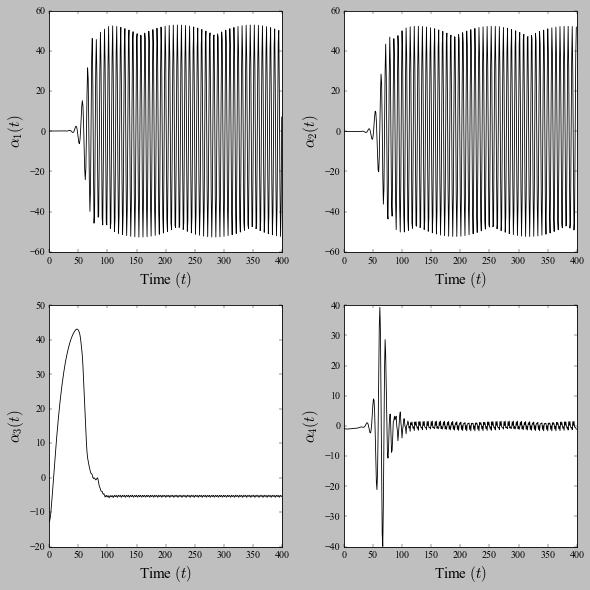

In [37]:
m=2
n = num_pod_modes//m
plt.figure(figsize=(5*num_pod_modes//2,10), tight_layout=True, dpi=DPI)
for i in range(num_pod_modes):
    plt.subplot(num_pod_modes//2,2,i+1)
    plt.plot(pod_modes[:,i], 'k')
    plt.xlabel("Time $(t)$",fontsize=18)
    # plt.ylabel("Value",fontsize=18)
    plt.ylabel('$\\alpha_{}(t)$'.format(i+1),fontsize=18)
plt.savefig('../out/vks_pod_modes.pdf', format="pdf", bbox_inches="tight")


*POD Decay*

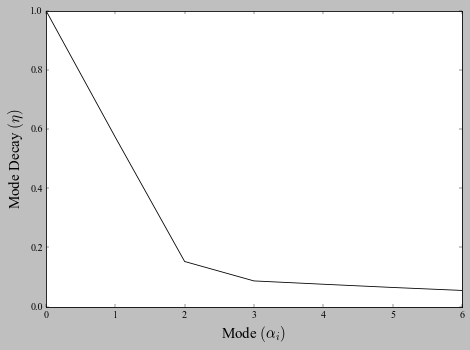

In [38]:
perc = 99.99
total = sum(eigenvalues)
data = []
cumulative=[1]

for eig in eigenvalues:
    val = eig/total
    if(val>100-perc):
        data = data + [val]
        cumulative = cumulative + [cumulative[-1]-val]

x = np.arange(0,len(data))
x2 = np.arange(0,len(cumulative))

#CUMULATIVE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.plot(x2,cumulative, 'k')
plt.xlabel('Mode $(\\alpha_i)$',fontsize=18)
plt.ylabel('Mode Decay $(\eta)$',fontsize=18)
plt.savefig('../out/vks_pod_decay.pdf', format="pdf", bbox_inches="tight")

## DMD

In [39]:
s_ind = 0
e_ind = 101
pred = vks.shape[0]
num_dmd_modes=4
X, Atilde,Ur,Phi,Lambda,Sigma,b = DMD2(vks, s_ind, e_ind, num_dmd_modes)
print(X.shape, Atilde.shape, Ur.shape, Phi.shape, Lambda.shape, Sigma.shape, b.shape)

(281790, 100) (4, 4) (281790, 4) (281790, 4) (4, 4) (100,) (4,)


In [40]:
dmd_modes = Phi.reshape([2]+list(vks.shape[1:-1])+[num_dmd_modes])
print(dmd_modes.shape)

(2, 505, 279, 4)


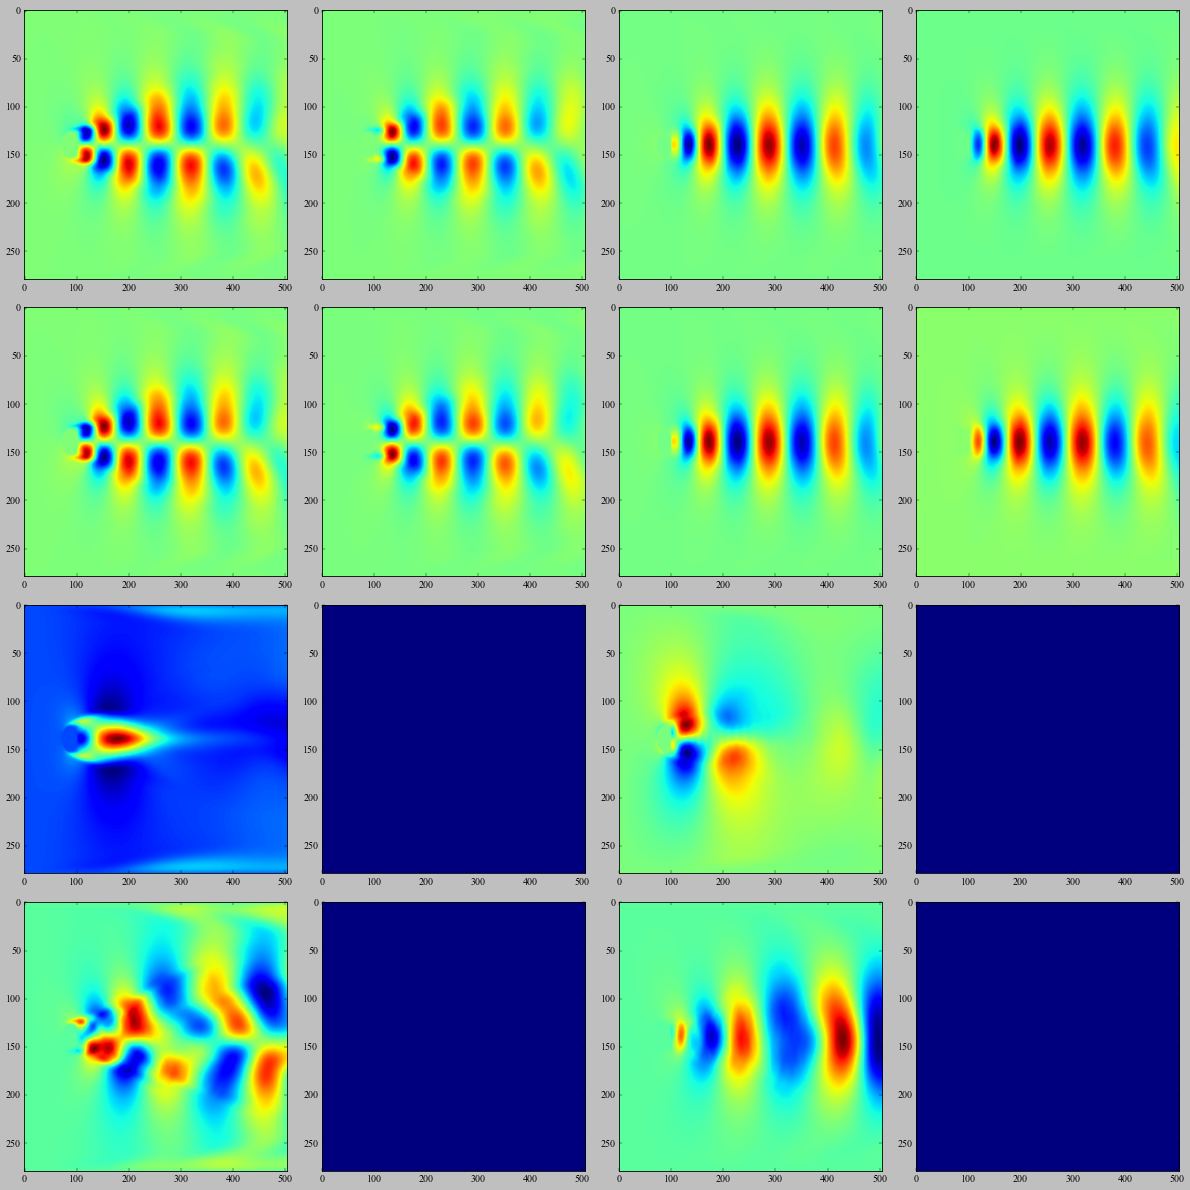

In [41]:
m=2
n = num_dmd_modes//m
plt.figure(figsize=(20,5*num_dmd_modes), tight_layout=True, dpi=DPI)
for i in range(num_dmd_modes):
    plt.subplot(num_dmd_modes,4,4*i+1)
    plt.imshow(np.real(dmd_modes[0,:,:,i].T),aspect='auto')
    plt.subplot(num_dmd_modes,4,4*i+2)
    plt.imshow(np.imag(dmd_modes[0,:,:,i].T),aspect='auto')
    plt.subplot(num_dmd_modes,4,4*i+3)
    plt.imshow(np.real(dmd_modes[1,:,:,i].T),aspect='auto')
    plt.subplot(num_dmd_modes,4,4*i+4)
    plt.imshow(np.imag(dmd_modes[1,:,:,i].T),aspect='auto')
plt.savefig('../out/vks_dmd_modes.pdf', format="pdf", bbox_inches="tight")

In [42]:
%%capture
fig, axes = plt.subplots(2,1,tight_layout=True)
lines = []
for ax in axes.flatten():
    lines = lines + [ax.imshow(np.zeros(domain_shape),
                origin='upper', vmin=-.4, vmax=.4, aspect='auto')]

def run(vks_t):
    Lambda_k = np.linalg.matrix_power(Lambda,vks_t)
    Xk=Phi@Lambda_k@b
    var1_xk = np.real(Xk[:domain_len].reshape(domain_shape))
    var2_xk = np.real(Xk[domain_len:].reshape(domain_shape))
    lines[0].set_data(var1_xk.T)
    lines[1].set_data(var2_xk.T)
    return lines

ani = animation.FuncAnimation(fig, run, blit=True, interval=pred,
    repeat=False)

ani.save('../out/vks_dmd_recon.gif', "PillowWriter", fps=6)

![animation](../out/vks_dmd_recon.gif)

# KPP Equations

In [43]:
npdata = np.load(KPP_DIR)
xv, yv, kpp = npdata['arr_0'], npdata['arr_1'], npdata['arr_2']
kpp = np.moveaxis(kpp, 2,0)
print('Data Shape: {}'.format(kpp.shape))
time_len = kpp.shape[0]
domain_shape =kpp.shape[1:]
domain_len =kpp.shape[1]*kpp.shape[2]

Data Shape: (501, 20, 20)


In [44]:
%%capture
plt.style.use('default')
# plt.rcParams['font.size']=28
fig = plt.figure(tight_layout=True)
ax1 = fig.add_subplot(projection='3d')
ax1.set_zlim(0, 10)
lines =[ax1.plot_surface(xv, yv, np.ones((20,20)), cmap=cm.coolwarm, linewidth=0)]

def kpp_init_anim(kpp_t):
    ax1.clear()
    ax1.set_zlim(0, 10)
    lines =[ax1.plot_surface(xv, yv, kpp[kpp_t,:,:], cmap=cm.coolwarm, linewidth=0)]
    return lines

ani = animation.FuncAnimation(fig, kpp_init_anim, blit=True, interval=kpp.shape[0]-1,
    repeat=False)
ani.save('../out/kpp_init_data.gif', "PillowWriter", fps=6);

![kpp_init](../out/kpp_init_data.gif)

## POD Decomposition

In [45]:
s_ind = 0
e_ind = time_len
num_pod_modes = 4
spatial_modes, pod_modes, eigenvalues, kpp_mnstrt= PODKPP(kpp, s_ind, e_ind, num_pod_modes)
print("REDUCED MODEL SHAPE: {}".format(pod_modes.shape))

REDUCED MODEL SHAPE: (501, 4)


*Mean Subtracted Data*

In [46]:
%%capture
plt.style.use('default')
# plt.rcParams['font.size']=28
fig = plt.figure(tight_layout=True)
ax1 = fig.add_subplot(projection='3d')
min_,max_ = np.min(kpp_mnstrt), np.max(kpp_mnstrt)
val = max(abs(min_),abs(max_))
ax1.set_zlim(-val,val)
lines =[ax1.plot_surface(xv, yv, np.zeros(domain_shape), cmap=cm.coolwarm, linewidth=0, antialiased=False)]

def kpp_mnstrt_anim(kpp_t):
    ax1.clear()
    ax1.set_zlim(-val,val)
    data = kpp_mnstrt[kpp_t,:].reshape(domain_shape)
    lines =[ax1.plot_surface(xv,yv,data,cmap=cm.coolwarm,linewidth=0)]
    return lines

ani = animation.FuncAnimation(fig, kpp_mnstrt_anim, blit=True, interval=kpp.shape[0]-1,
    repeat=False)

ani.save('../out/kpp_mnstrt_data.gif', "PillowWriter", fps=6);

![anim](../out/kpp_mnstrt_data.gif)

In [47]:
kpp_reconstructed = pod_modes@spatial_modes.T
#RESHAPE INTO MODES
kpp_reconstructed = kpp_reconstructed.reshape(kpp.shape)

*POD reconstructed Data*

In [48]:
%%capture
plt.style.use('default')
# plt.rcParams['font.size']=28
fig = plt.figure(tight_layout=True)
ax1 = fig.add_subplot(projection='3d')
min_,max_ = np.min(kpp_reconstructed), np.max(kpp_reconstructed)
val = max(abs(min_),abs(max_))
ax1.set_zlim(-val,val)
lines =[ax1.plot_surface(xv, yv, np.zeros(domain_shape), cmap=cm.coolwarm, linewidth=0, antialiased=False)]

def kpp_pod_lines(kpp_t):
    ax1.clear()
    ax1.set_zlim(-val,val)
    data = kpp_reconstructed[kpp_t,:]
    lines =[ax1.plot_surface(xv,yv,data,cmap=cm.coolwarm,linewidth=0)]
    return lines

ani = animation.FuncAnimation(fig, kpp_pod_lines, blit=True, interval=kpp.shape[0]-1,
    repeat=False)

ani.save('../out/kpp_pod_recon.gif', "PillowWriter", fps=6)

![anim](../out/kpp_pod_recon.gif)

*POD Modes*

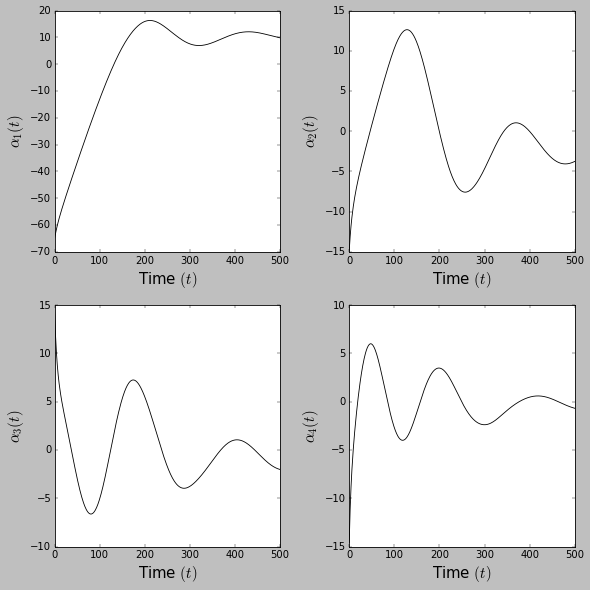

In [49]:
m=2
plt.style.use('classic')
n = num_pod_modes//m
plt.figure(figsize=(5*num_pod_modes//2,10), tight_layout=True, dpi=DPI)
for i in range(num_pod_modes):
    plt.subplot(num_pod_modes//2,2,i+1)
    plt.plot(pod_modes[:,i], 'k')
    plt.xlabel("Time $(t)$",fontsize=18)
    # plt.ylabel("Value",fontsize=18)
    plt.ylabel('$\\alpha_{}(t)$'.format(i+1),fontsize=18)
plt.savefig('../out/kpp_pod_modes.pdf', format="pdf", bbox_inches="tight")

*POD Decay*

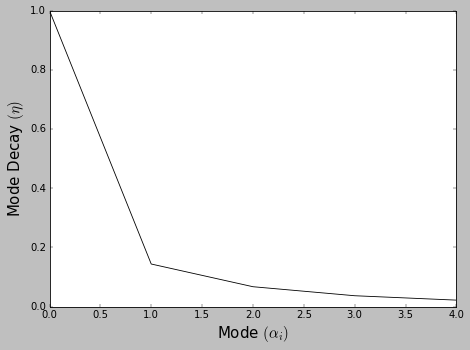

In [50]:
perc = 99.99
total = sum(eigenvalues)
data = []
cumulative=[1]

for eig in eigenvalues:
    val = eig/total
    if(val>100-perc):
        data = data + [val]
        cumulative = cumulative + [cumulative[-1]-val]

x = np.arange(0,len(data))
x2 = np.arange(0,len(cumulative))

#CUMULATIVE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.plot(x2,cumulative, 'k')
plt.xlabel('Mode $(\\alpha_i)$',fontsize=18)
plt.ylabel('Mode Decay $(\eta)$',fontsize=18)
plt.savefig('../out/kpp_pod_decay.pdf', format="pdf", bbox_inches="tight")

# Euler Equations

In [51]:
npzdata = np.load(EE_DIR)
param = 50
rho, u, E, x, params, t = npzdata['arr_0'], npzdata['arr_1'], npzdata['arr_2'], npzdata['arr_3'], npzdata['arr_4'], npzdata['arr_5']
ee = np.array([rho[:,:,param], u[:,:,param], E[:,:,param]])
ee = np.moveaxis(ee,0,-1)
print('Data Shape: {}'.format(ee.shape))
end = ee.shape[2]

Data Shape: (500, 626, 3)


In [ ]:
def ee_plot(ee_t1, ee_p1, ee_t2, ee_p2):
    plt.figure(figsize=(16, 6), dpi=80)
    plt.subplot(131)
    plt.plot(x, rho[:,ee_t1,ee_p1], 'g--', label = 'param1')
    plt.plot(x, rho[:,ee_t2,ee_p2], 'r', label = 'param2')
    plt.legend()
    plt.title('Density $\\rho$')
    
    plt.subplot(132)
    plt.plot(x, u[:,ee_t1,ee_p1], 'g--', label = 'param1')
    plt.plot(x, u[:,ee_t2,ee_p2], 'r', label = 'param2')
    plt.title('Velocty $u$')
    plt.xlabel('$x$')

    plt.subplot(133)
    plt.plot(x, E[:,ee_t1,ee_p1], 'g--', label = 'param1')
    plt.plot(x, E[:,ee_t2,ee_p2], 'r', label = 'param2')
    plt.title('Energy $E$')
    plt.xlabel('$x$')

interact_manual(ee_plot, ee_t1 = widgets.IntSlider(value=0,
                                               min=0,
                                               max=len(t)-1,
                                               step=1),
                     ee_p1 = widgets.IntSlider(value=0,
                                               min=0,
                                               max=100-1,
                                               step=1),
                     ee_t2 = widgets.IntSlider(value=20,
                                               min=0,
                                               max=len(t)-1,
                                               step=1),
                    ee_p2 = widgets.IntSlider(value=0,
                                               min=0,
                                               max=100-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='ee_t1', max=625), IntSlider(value=0, description='ee_p1'…

<function __main__.ee_plot(ee_t1, ee_p1, ee_t2, ee_p2)>

In [ ]:
s_ind = 0
e_ind = end
pod_modes = 4
#spatial_modes, data_ROM, eigenvalues, Ux_LES = POD1(np.nan_to_num(rho[:,:,1]).T, s_ind, e_ind, pod_modes)
spatial_modes, data_ROM, eigenvalues, Ux_LES, Uy_LES, Uz_LES = POD3(np.nan_to_num(ee), s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data_ROM.shape))

REDUCED MODEL SHAPE: (626, 4)


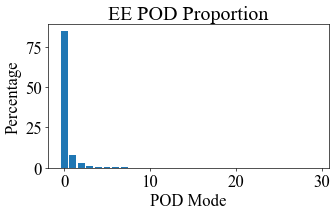

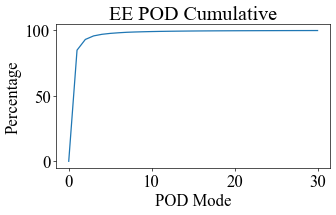

In [ ]:
perc = 99.99
total = sum(eigenvalues)
data = []
cumulative=[0]

for eig in eigenvalues:
    val = eig/total*100
    if(val>100-perc):
        data = data + [val]
        cumulative = cumulative + [val+cumulative[-1]]

x = np.arange(0,len(data))
x2 = np.arange(0,len(cumulative))

#PERCENTAGE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.title("EE POD Proportion")
plt.bar(x,data)
plt.xlabel('POD Mode')
plt.ylabel('Percentage')
plt.savefig('../out/EE/podPercentage.pdf', format="pdf", bbox_inches="tight")
#CUMULATIVE PLOT
#CUMULATIVE PLOT
plt.figure(tight_layout=True, dpi=DPI)
plt.title("EE POD Cumulative")
plt.plot(x2,cumulative)
plt.xlabel('POD Mode')
plt.ylabel('Percentage')
plt.savefig('../out/EE/podCumulative.pdf', format="pdf", bbox_inches="tight")

No handles with labels found to put in legend.


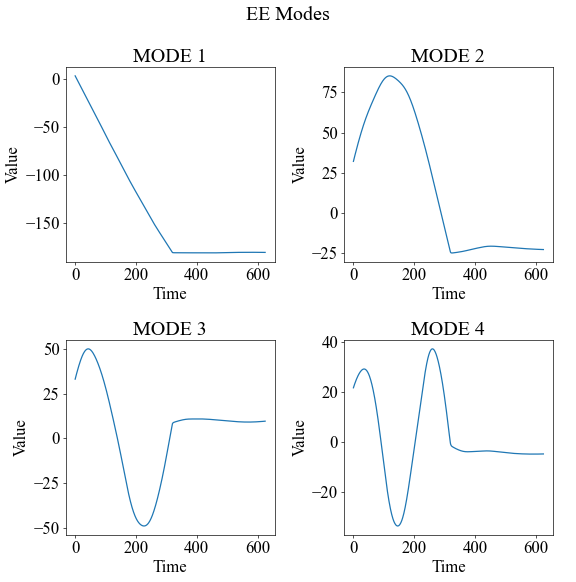

In [ ]:
m=2
n = pod_modes//m
plt.figure(figsize=(5*pod_modes//2,10), tight_layout=True, dpi=DPI)
plt.suptitle("EE Modes")
for i in range(pod_modes):
    plt.subplot(pod_modes//2,2,i+1)
    plt.plot(data_ROM[:,i])
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title('MODE {}'.format(i+1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10}, frameon=False)
plt.savefig('../out/EE/podModes.pdf', format="pdf", bbox_inches="tight")


In [ ]:
s_ind = 0
e_ind = 5000
pod_modes = 20
spatial_modes, data_ROM, eigenvalues, Ux_LES = POD1(np.nan_to_num(rho[:,:,1]).T, s_ind, e_ind, pod_modes)
#spatial_modes, data_ROM, eigenvalues, Ux_LES, Uy_LES, Uz_LES = POD3(np.nan_to_num(ee), s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data_ROM.shape))

REDUCED MODEL SHAPE: (626, 20)


[51234.12021945 35296.98095501 18004.97087511 13362.16737585
  7591.54981619  6274.9195913   3444.34331557  2415.8539439
  2009.99091294  1447.56688725  1112.48616208  1028.06489317]


<BarContainer object of 58 artists>

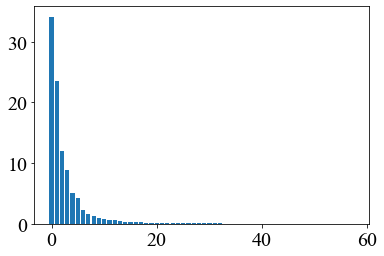

In [ ]:
perc = 99.99
total = eigenvalues.sum()
data = []

print(eigenvalues[:12])

for eig in eigenvalues:
    val = eig/total*100
    if(val>100-perc):
        data = data + [val]

x_ = np.arange(0,len(data))

plt.figure()
plt.bar(x_,data)

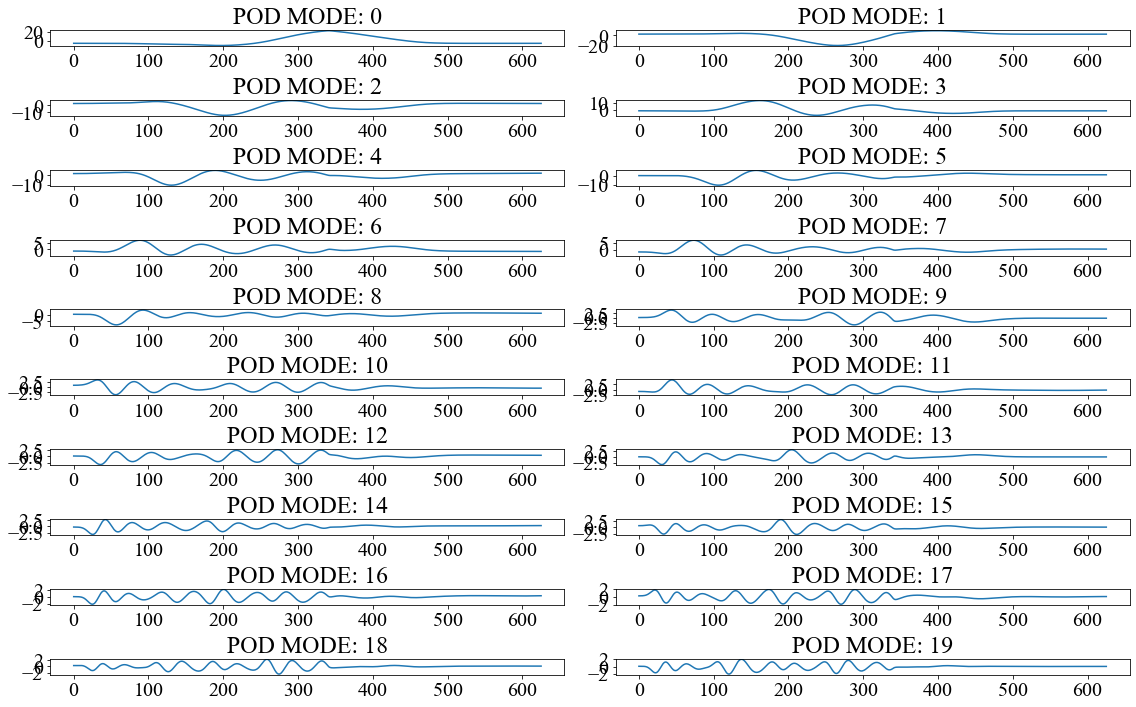

In [ ]:
m=2
n = pod_modes//m
fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(16,10))
fig.tight_layout()
for i,ax in enumerate(axs):
    for j in range(m):
        ax[j].plot(data_ROM[:,i*m+j])
        ax[j].set_title('POD MODE: {}'.format(i*m+j))

In [ ]:
pod_true = np.matmul(data_ROM, spatial_modes.T)
print(pod_true.shape)

(626, 500)


In [ ]:
def ee_Reconstructed(rec_ee_t):
    plt.figure(figsize=(10,10), tight_layout=True)

    plt.subplot(121)
    plt.plot(pod_true[rec_ee_t,:])
    plt.title('ROM h(x)')

    plt.subplot(122)
    plt.plot(rho[:,rec_ee_t,param])
    plt.title('True h(x)')

interact_manual(ee_Reconstructed, rec_ee_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=ee.shape[2]-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='rec_ee_t', max=625), Button(description='Run Interact', …

<function __main__.ee_Reconstructed(rec_ee_t)>

# Fiber
*LOAD DATA*

In [ ]:
fiber = pd.read_table(FIB_DIR, sep="\t", index_col=2, names=["x", "h"]).to_numpy()
m = fiber.shape[0]//401
x = fiber[:,0].reshape(m,401)
fiber = fiber[:,1].reshape(m,401)
print(fiber.shape)

(426, 401)


In [ ]:
def fib_plot(fib_t):
    plt.figure(figsize=(16, 6), dpi=80)
    y = fiber[fib_t, :]
    plt.plot(y)
    plt.ylim((0,1))
    plt.title('Height along the rod at time {}'.format(fib_t))
    
interact(fib_plot, fib_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=m-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='fib_t', max=425), Output()), _dom_classes=('widget-inter…

<function __main__.fib_plot(fib_t)>

In [ ]:
s_ind = 0
e_ind = fiber.shape[0]
pod_modes = 12
spatial_modes, data_ROM, eigenvalues, Ux_rom = POD1(fiber, s_ind, e_ind, pod_modes)
print("REDUCED MODEL SHAPE: {}".format(data_ROM.shape))


REDUCED MODEL SHAPE: (426, 12)


[3.06951315e+03 2.93332834e+03 8.69553464e+02 8.21023313e+02
 6.66149232e+01 4.57597947e+01 4.38197519e+01 9.56338864e+00
 9.29750287e+00 3.07583424e+00 2.99895789e+00 7.69026350e-01]


<BarContainer object of 11 artists>

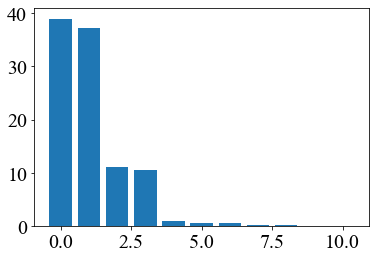

In [ ]:
perc = 99.99
total = eigenvalues.sum()
data = []

print(eigenvalues[:12])

for eig in eigenvalues:
    val = eig/total*100
    if(val>100-perc):
        data = data + [val]

x = np.arange(0,len(data))

plt.figure()
plt.bar(x,data)

In [ ]:
def fibRom_plot(fibRom_t):
    plt.figure(figsize=(16, 6), dpi=80)
    y = Ux_rom[fibRom_t, :]
    plt.ylim((-.5,.5))
    plt.plot(y)
    plt.title('Height along the rod at time {}'.format(fibRom_t))
    
interact(fibRom_plot, fibRom_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=m-1,
                                               step=1))

interactive(children=(IntSlider(value=0, description='fibRom_t', max=425), Output()), _dom_classes=('widget-in…

<function __main__.fibRom_plot(fibRom_t)>

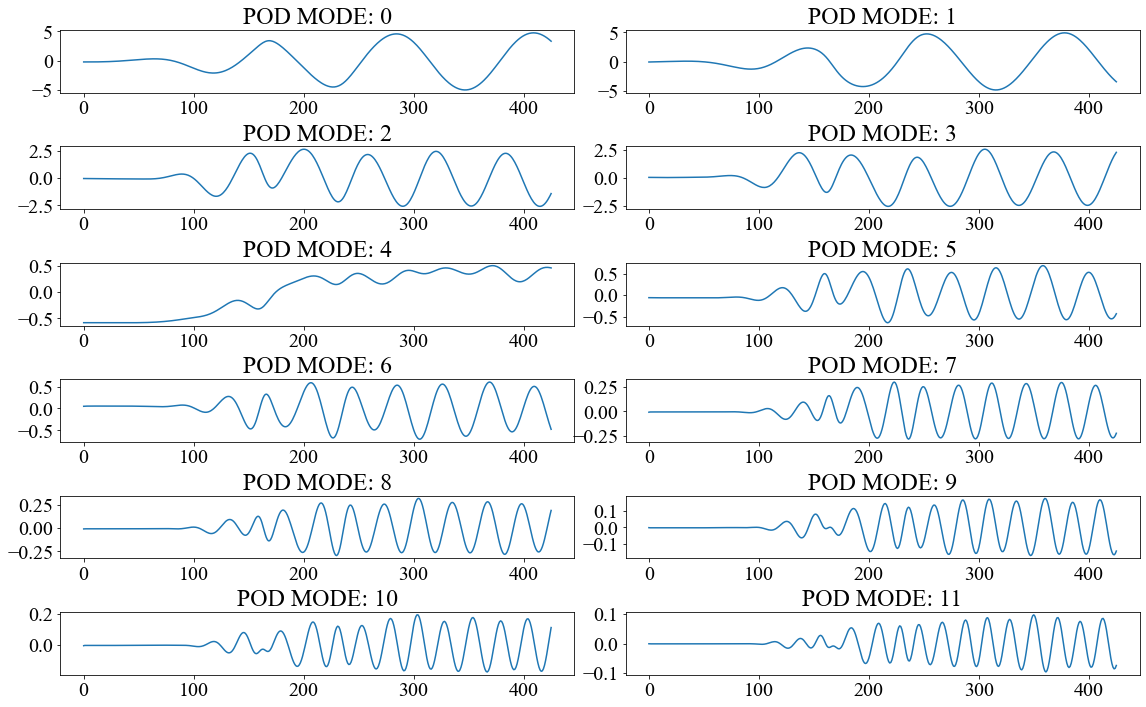

In [ ]:
m=2
n = pod_modes//m
fig, axs = plt.subplots(nrows=n, ncols=m, figsize=(16,10))
fig.tight_layout()
#double check
for i,ax in enumerate(axs):
    for j in range(m):
        ax[j].plot(data_ROM[:,i*m+j])
        ax[j].set_title('POD MODE: {}'.format(i*m+j))

In [ ]:
pod = np.matmul(data_ROM, spatial_modes.T)
def fibPod_plot(fibPod_t):
    plt.figure(figsize=(16, 6), dpi=80)
    y = pod[fibPod_t, :]
    plt.plot(y)
    plt.title('Height along the rod at time {}'.format(fibPod_t))
    
interact(fibPod_plot, fibPod_t = widgets.IntSlider(value=0,
                                               min=0,
                                               max=m,
                                               step=1))

interactive(children=(IntSlider(value=0, description='fibPod_t', max=2), Output()), _dom_classes=('widget-inte…

<function __main__.fibPod_plot(fibPod_t)>